<a href="https://colab.research.google.com/github/Utkarshp1/Bayesian_Optimisation/blob/master/Gaussian_Processes_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression using GPytorch

In [1]:
!pip install gpytorch

     |████████████████████████████████| 501kB 6.8MB/s 


In [2]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Train an RBF kernel Gaussian process on a simple function. We'll be modelling the function <br />
$$ y = sin(2\pi x) + \epsilon $$
$$ \epsilon \stackrel{}{\sim} \mathcal{N}(0, 0.04) $$

In [16]:
X_train = torch.linspace(0, 1, 10)
y_train = torch.sin(X_train * (2*math.pi)) + torch.randn(X_train.size())*math.sqrt(0.04)

In [17]:
# X's which will be used for sampling and plotting the sampled function
plotting_x = torch.linspace(-0.5, 1.5, 10000)

## Model Definition

In [22]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.rbf_kernel = gpytorch.kernels.RBFKernel() 
        self.covar_module = gpytorch.kernels.ScaleKernel(self.rbf_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [23]:
# Initial value of the lengthscale paramter of the Kernel = 1
model.rbf_kernel.has_lengthscale = True
model.rbf_kernel.lengthscale = torch.tensor(0.1)

**INTERLUDE: Calculating the value of kernel**

```python
    tensor = torch.tensor([1, 2])
    lazy_evaluate = model.rbf_kernel(tensor1)
    tensor_evluated = lazy_evaluate.evaluate()
```

## Prior Distribution and Sampling from Prior

In [24]:
# Getting the prior probability
prior = model.forward(plotting_x)
print(type(prior))

# Getting 2 sample function from the prior distribution
prior_samples = prior.rsample(sample_shape=torch.Size([2]))
prior_samples.shape

<class 'gpytorch.distributions.multivariate_normal.MultivariateNormal'>


torch.Size([2, 10000])

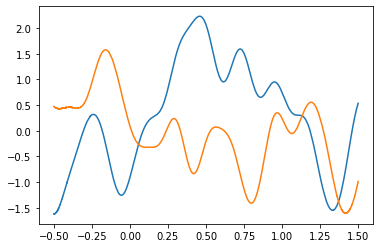

In [25]:
# plotting the sampled functions
plt.figure()
for i in range(2):
    plt.plot(plotting_x, prior_samples[i, :].detach().numpy())
plt.show()

In [26]:
# Getting the 95% confidence interval for the function value
ci = prior.confidence_region()
ci[0].shape, ci[1].shape

(torch.Size([10000]), torch.Size([10000]))

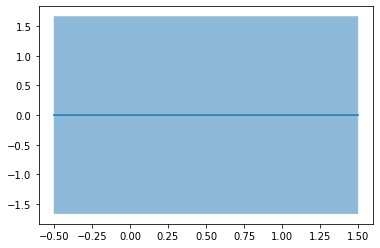

In [27]:
# Plotting the 95% confidence interval with the mean for the function value
with torch.no_grad():
    plt.figure()
    plt.plot(plotting_x, prior.mean.numpy())
    plt.fill_between(plotting_x, ci[0].numpy(), ci[1].numpy(), alpha=0.5)
    plt.xlim()
    plt.show()

## Training Loop

In [28]:
training_iter = 20

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1) # Includes GaussianLikelihood parameters

# "loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calculate loss and backpropagate gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  lengthscale: %.3f   noise: %.3f' % (
        i+1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/20 - Loss: 1.216  lengthscale: 0.100   noise: 0.693
Iter 2/20 - Loss: 1.197  lengthscale: 0.251   noise: 0.313
Iter 3/20 - Loss: 1.269  lengthscale: 0.537   noise: 0.130
Iter 4/20 - Loss: 0.964  lengthscale: 0.381   noise: 0.167
Iter 5/20 - Loss: 0.954  lengthscale: 0.218   noise: 0.198
Iter 6/20 - Loss: 1.105  lengthscale: 0.151   noise: 0.195
Iter 7/20 - Loss: 1.121  lengthscale: 0.138   noise: 0.171
Iter 8/20 - Loss: 1.012  lengthscale: 0.158   noise: 0.137
Iter 9/20 - Loss: 0.861  lengthscale: 0.205   noise: 0.102
Iter 10/20 - Loss: 0.761  lengthscale: 0.282   noise: 0.072
Iter 11/20 - Loss: 0.890  lengthscale: 0.373   noise: 0.051
Iter 12/20 - Loss: 0.850  lengthscale: 0.339   noise: 0.041
Iter 13/20 - Loss: 0.812  lengthscale: 0.267   noise: 0.037
Iter 14/20 - Loss: 0.812  lengthscale: 0.210   noise: 0.038
Iter 15/20 - Loss: 0.828  lengthscale: 0.170   noise: 0.040
Iter 16/20 - Loss: 0.839  lengthscale: 0.147   noise: 0.040
Iter 17/20 - Loss: 0.801  lengthscale: 0.143   no

## Make predictions with the model

In [29]:
# Switch on the evaluation mode to get the predictions
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Posterior Distribution and Sampling from Posterior

The samples are drawn after 20 epochs of training. With more epochs of training better fit can be obtained.

In [30]:
posterior = model(plotting_x)
posterior_samples = posterior.rsample(sample_shape=torch.Size([2]))
posterior_samples.shape

torch.Size([2, 10000])

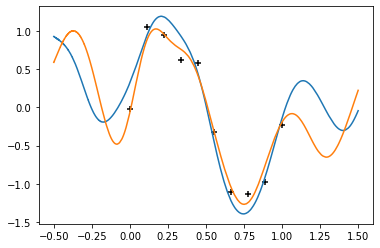

In [31]:
with torch.no_grad():
    plt.figure()
    plt.scatter(X_train, y_train, c='black', marker='+')
    for i in range(2):
        plt.plot(plotting_x, posterior_samples[i, :].numpy())
    plt.show()

In [32]:
ci = posterior.confidence_region()
ci[0].shape, ci[1].shape

(torch.Size([10000]), torch.Size([10000]))

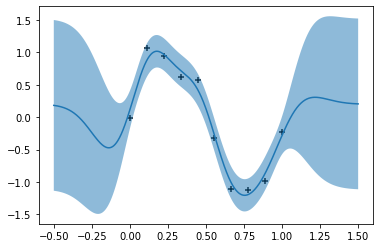

In [33]:
with torch.no_grad():
    plt.figure()
    plt.scatter(X_train, y_train, c='black', marker='+')
    plt.plot(plotting_x, posterior.mean.numpy())
    plt.fill_between(plotting_x, ci[0].numpy(), ci[1].numpy(), alpha=0.5)
    plt.show()

In [ ]:
f_preds = model(X_test)
y_preds = likelihood(model(X_test))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_test = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(X_test))

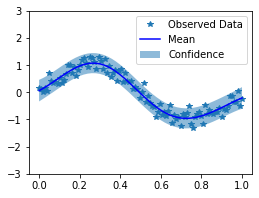

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), y_train.numpy(), '*')
    # Plot predictive means as blue line
    ax.plot(X_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
X_test = torch.linspace(0, 1, 51)
y_test = torch.sin(X_test * (2*math.pi)) + torch.randn(X_test.size())*math.sqrt(0.04)